In [ ]:
'''

'''

In [431]:
import pandas as pd
import numpy as np

from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import shap
import networkx as nx

import matplotlib.pyplot as plt

from IPython.display import display

In [146]:
class DivorceDataset:
    def __init__(self, ds, conf):
        try:
            self.x = ds.loc[ : , ds.columns != 'Divorce'].copy().values.astype(np.float32)
            # self.x = self.x.values.tolist()
            self.Y = ds.loc[ : , ds.columns == 'Divorce'].copy().values.astype(np.float32)
            # self.Y = self.Y.values.tolist()
        except Exception as e:
            raise e
    
    def __len__(self):
        try:
            return len(self.Y)
        except Exception as e:
            raise e 
    
    def __getitem__(self, idx):
        try:
            return self.x[idx], self.Y[idx]
        except Exception as e:
            raise e

In [150]:
class DivorceDatasetUtil:
    def __init__(self, conf):
        try:
            self.dataset = pd.read_csv(conf['data_fl_path'], sep=';')
            
            self.meta = {
                'fetures': [col for col in self.dataset.columns if col != 'Divorce'],
                'labels': ['Divorce']
            }
        except Exception as e:
            raise e
    
    def data_split(self, conf):
        try:
            dataset = DivorceDataset(self.dataset, conf)
            train_dataset, val_dataset, test_dataset= random_split(dataset, conf['data_split_ratio'] , generator=torch.Generator().manual_seed(42))
            
            return train_dataset, val_dataset, test_dataset
            
        except Exception as e:
            raise e
            
    def get_meta(self):
        try:
            return self.meta
        except Exception as e:
            raise e

In [130]:
class DivorceModel(nn.Module):
    def __init__(self, conf, **kwargs):
        super(DivorceModel, self).__init__(**kwargs)
        self.divorce_layer = nn.Sequential(
                OrderedDict([
                    ('1_LINEAR', nn.Linear(in_features=54, out_features=40, device=conf['device'])),
                    ('2_LINEAR', nn.Linear(in_features=40, out_features=20, device=conf['device'])),
                    ('3_LINEAR', nn.Linear(in_features=20, out_features=10, device=conf['device'])),
                    ('4_LINEAR', nn.Linear(in_features=10, out_features=1, device=conf['device']))
                ])
            )
        
    def forward(self, x):
        
        linear_layer_1 = self.divorce_layer._modules['1_LINEAR']
        linear_layer_1_op = linear_layer_1(x)
        # print("linear_layer_1_op :- ", linear_layer_1_op.shape)

        linear_layer_2 = self.divorce_layer._modules['2_LINEAR']
        linear_layer_2_op = linear_layer_2(linear_layer_1_op)
        # print("linear_layer_2_op :- ", linear_layer_2_op.shape)
        
        linear_layer_3 = self.divorce_layer._modules['3_LINEAR']
        linear_layer_3_op = linear_layer_3(linear_layer_2_op)
        # print("linear_layer_3_op :- ", linear_layer_3_op.shape)
        
        linear_layer_4 = self.divorce_layer._modules['4_LINEAR']
        linear_layer_4_op = linear_layer_4(linear_layer_3_op)
        # print("linear_layer_4_op :- ", linear_layer_4_op.shape)

        return linear_layer_4_op
        

In [258]:
class DivorceModelUtil:
    def __init__(self, conf):
        try:
            self.model = DivorceModel(conf)
            self.loss_fn = torch.nn.BCEWithLogitsLoss()
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
            
        except Exception as e:
            raise e
    
    def train(self, train_ds, valid_ds, conf):
        try:
            train_dataloader = DataLoader(train_ds, batch_size=conf['data_batch_size'][0], shuffle=True)
            
            for epoch in range(conf['epochs']+1):
                training_loss = 0
                for train_idx, (train_x, train_Y) in enumerate(train_dataloader):
                    
                    # Zero your gradients for every batch!
                    self.optimizer.zero_grad()
                    
                    # Make predictions for this batch
                    outputs = self.model(train_x)
                    
                    # Compute the loss and its gradients
                    loss = self.loss_fn(outputs, train_Y)
                    loss.backward()
                    
                    # Adjust learning weights
                    self.optimizer.step()
                    
                    # Gather data and report
                    training_loss += loss.item()
                    
                training_loss = training_loss/len(train_dataloader)
                if epoch%10 == 0:
                    self.model.eval() # evaluate mode 
                    valid_loss = self.validation(valid_ds, conf)
                    print(f"epoch:- {epoch}, train loss:- {training_loss}, validation loss:- {valid_loss}")
                    self.model.train() # train mode 

            # save the model
            self.save_model(conf)
                    
        except Exception as e:
            raise e
        
    def validation(self, ds, conf):
        try:
            valid_dataloader = DataLoader(ds, batch_size=conf['data_batch_size'][1], shuffle=True)
            valid_loss = 0
            with torch.no_grad():
                for valid_idx, (valid_x, valid_Y) in enumerate(valid_dataloader):
                    outputs = self.model(valid_x)
                    loss = self.loss_fn(outputs, valid_Y)
                    valid_loss += loss.item()

                valid_loss = valid_loss/len(valid_dataloader)
            return valid_loss
        except Exception as e:
            raise e
            
    def test(self, ds, conf):
        try:
            self.load_model(conf)
            test_dataloader = DataLoader(ds, batch_size=conf['data_batch_size'][2], shuffle=True)
            test_loss = 0
            with torch.no_grad():
                for test_idx, (test_x, test_Y) in enumerate(test_dataloader):
                    outputs = self.model(test_x)
                    loss = self.loss_fn(outputs, test_Y)
                    test_loss += loss.item()

                test_loss = test_loss/len(test_dataloader)
            print(f"train test_loss:- {test_loss}")
        except Exception as e:
            raise
            
    def predict(self, x):
        try:
            # convert numpy array to tensor
            xTensor = torch.tensor(x, dtype=torch.float32).to('cpu')
            m = nn.Sigmoid()
            with torch.no_grad():
                probs = m(self.model(xTensor))
            return probs.numpy()
        except Exception as e:
            raise e
    
    def save_model(self, conf):
        try:
            torch.save({'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                       }, conf['model_path'])
        except Exception as e:
            raise e
            
    def load_model(self, conf):
        try:
            checkpoint = torch.load(conf['model_path'], map_location=conf['device'])
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        except Exception as e:
            raise e

In [259]:
def get_conf():
    try:
        conf = {
            "data_fl_path": "/Users/jaydeepchakraborty/JC/git-projects/model_util/DataSets/DivorcePrediction/divorce_data.csv",
            "data_split_ratio": [0.7, 0.2, 0.1],
            "data_batch_size": [10, 2, 2],
            "device": None,
            "epochs": 100,
            "model_path": "/Users/jaydeepchakraborty/JC/git-projects/model_util/Models/CausalInference/divorce.pt" 
        }
        
        return conf
    except Exception as e:
        raise e

In [260]:
def main():
    try:
        conf = get_conf()
        
        ds_util = DivorceDatasetUtil(conf)
        train_dataset, val_dataset, test_dataset = ds_util.data_split(conf)
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        conf['device'] = device
        model = DivorceModelUtil(conf)
        model.train(train_dataset, val_dataset, conf)  
        model.test(test_dataset, conf)
        
    except Exception as e:
        raise e

In [319]:
# def abcd():
#     try:
#         conf = get_conf()
        
#         ds_util = DivorceDatasetUtil(conf)
        
#         shap_x = ds_util.dataset.loc[ : , ds_util.dataset.columns != 'Divorce'].copy()
#         shap_Y = ds_util.dataset.loc[ : , ds_util.dataset.columns == 'Divorce'].copy()
          
#         shap_x = shap_x.to_numpy()
#         shap_Y = shap_Y.to_numpy()
    
        
#         shap_train_x = shap_x[1:len(shap_x), :]
#         shap_train_Y = shap_Y[1:len(shap_Y), :]
        
#         shap_test_x = shap_x[0:1, :]
#         shap_test_Y = shap_Y[0:1, :]
        
#         model_util = DivorceModelUtil(conf)
#         model_util.load_model(conf)
        
        
#         explainer = shap.Explainer(model_util.predict, shap_test_x)
#         sv = explainer(shap_test_x)
        
#         shap.initjs()
#         idx = 0
#         exp = shap.Explanation(sv.values, sv.base_values[0][0], sv.data)
#         fig = plt.figure(figsize=(10,5))
#         shap.plots.waterfall(exp[idx])
        
#         feature_names = ds_util.get_meta()['fetures']
        
#         print(f"actual label:- {shap_test_Y}")
#         print(f"predicted label:- {model_util.predict(shap_test_x)}")
        
#         # shap.summary_plot(shap_values, shap_test_x, feature_names)
#         # shap.plots.bar(shap_values, max_display=10)
#         # shap.plots.heatmap(shap_values)
        
#         # explainer = shap.Explainer(model.predict, data)
#         # sv = explainer(data)
#         # shap.plots.waterfall(exp[0])
        
#         # shap.initjs()
#         # def p(j):
#         #     return(shap.force_plot(explainer.expected_value, shap_values[j,:], shap_test_x.iloc[j,:]))
#         # p(0)
        
#         # explainer = shap.KernelExplainer(model_util.predict, shap.sample(shap_train_x, 25))
#         # shap_values = explainer.shap_values(shap_test_x, silent=True)  # suppress progress bar
#         # shap.decision_plot(explainer.expected_value, shap_values[0], shap_test_x)
        
#         print("Done ")
        
# #         model = DivorceModelUtil(conf)
# #         model.load_model(conf)
        
# #         torch.set_grad_enabled(True)
# #         e = shap.DeepExplainer(model.model, shape_x)
# #         shap_values = e.shap_values(shape_x)
# #         # Enable the plots in jupyter
# #         shap.initjs()

# #         feature_names = ds_util.get_meta()['fetures']
# #         print(feature_names)
# #         # Plots
        
# #         shap.summary_plot(shap_values, shape_x, feature_names)
        
        

# #         shap.plots.scatter(e, ylabel="SHAP value\n(higher means more likely to renew)")


        
#     except Exception as e:
#         raise e

In [428]:
def abcd():
    try:
        conf = get_conf()
        
        ds_util = DivorceDatasetUtil(conf)
        
        shap_x = ds_util.dataset.loc[ : , ds_util.dataset.columns != 'Divorce'].copy()
        shap_Y = ds_util.dataset.loc[ : , ds_util.dataset.columns == 'Divorce'].copy()
          
        shap_x_np = shap_x.to_numpy()
        shap_Y_np = shap_Y.to_numpy()
    
        
        shap_train_x = shap_x_np[1:len(shap_x_np), :]
        shap_train_xTensor = torch.tensor(shap_train_x, dtype=torch.float32).to('cpu')
        shap_train_Y = shap_Y_np[1:len(shap_Y_np), :]
        shap_train_YTensor = torch.tensor(shap_train_Y, dtype=torch.float32).to('cpu')
        
        shap_test_x = shap_x_np[0:1, :]
        shap_test_xTensor = torch.tensor(shap_test_x, dtype=torch.float32).to('cpu')
        shap_test_Y = shap_Y_np[0:1, :]
        shap_test_YTensor = torch.tensor(shap_test_Y, dtype=torch.float32).to('cpu')
        
        model_util = DivorceModelUtil(conf)
        model_util.load_model(conf)
        
        explainer = shap.DeepExplainer(model_util.model, shap_train_xTensor)
        shap_values = explainer.shap_values(shap_test_xTensor)
        
        # shap.summary_plot(shap_values, plot_type='dot')
        # shap.decision_plot(base_value=explainer.expected_value, shap_values=shap_values)
        # shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=shap_test_x, matplotlib=True)
        
        y_cls = [0,1]
        row=0
        for which_class in y_cls:
            values = shap_values[row]
            base_values = explainer.expected_value[int(which_class)]
            data = shap_test_x[row]
            feature_names=shap_x.columns.tolist()
            print(feature_names)
            exp = shap.Explanation(values=values, base_values=base_values, data=data)
            display(shap.waterfall_plot(exp))

        
        print("Done ")
        
    except Exception as e:
        raise e

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46', 'Q47', 'Q48', 'Q49', 'Q50', 'Q51', 'Q52', 'Q53', 'Q54']


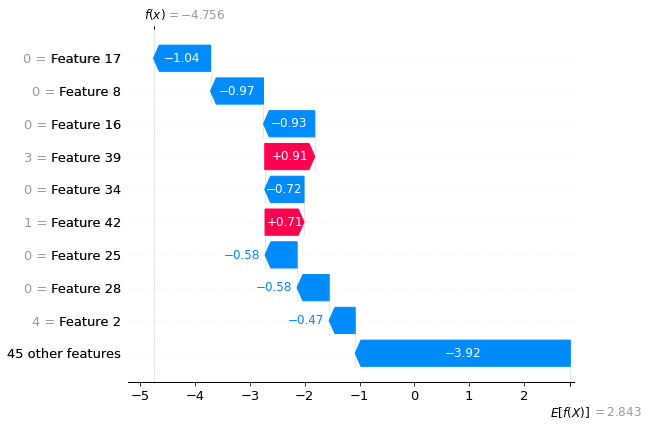

None

IndexError: index 1 is out of bounds for axis 0 with size 1

In [429]:
if __name__ == '__main__':
    # main()
    abcd()

# Resources
1) https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c
2) https://shap-lrjball.readthedocs.io/en/latest/
3) https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

In [22]:
# trainset, valset = random_split(dataset, [15593, 3898])

# train_loader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)
# val_loader = DataLoader(valset, batch_size=10, shuffle=True, num_workers=2)

# for i, batch in enumerate(train_loader):
#     print(i, batch)

# for i, batch in enumerate(val_loader):
#     print(i, batch)

In [430]:
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 kB 4.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 27.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 22.7 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
causal_graph = nx.DiGraph([('Page Views', 'Sold Units'),
                           ('Revenue', 'Profit'),
                           ('Unit Price', 'Sold Units'),
                           ('Unit Price', 'Revenue'),
                           ('Shopping Event?', 'Page Views'),
                           ('Shopping Event?', 'Sold Units'),
                           ('Shopping Event?', 'Unit Price'),
                           ('Shopping Event?', 'Ad Spend'),
                           ('Ad Spend', 'Page Views'),
                           ('Ad Spend', 'Operational Cost'),
                           ('Sold Units', 'Revenue'),
                           ('Sold Units', 'Operational Cost'),
                           ('Operational Cost', 'Profit')])

##############################################

<b>Doubly Robust Learning</b> <br>
$
\begin{align}
& \text{model_regression:} \\
& \bar{Y} = Y - E[Y|T, X, W] \\
& \bar{Y} \text{is residual} \\
& \text{model_propensity:} \\
& \bar{T} = T - E[T|X, W] \\
& \bar{Y} \text{is residual} \\
& \text{model_final:} \\
& \text{estimator for } \bar{Y} \text{ and } \bar{T}
\end{align}
$

In [ ]:
dr_train_Y = sales_df_train['Weekly_Sales'].copy()
dr_train_T = sales_df_train['Type'].copy()
dr_train_W = None
dr_train_Z = None
dr_train_X = sales_df_train[['Dept', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI']].copy()
cat_cols_name = [0, 1] # ['Dept', 'IsHoliday']

In [ ]:
dr_est = DRLearner(
                model_regression=HistGradientBoostingRegressor(random_state=42, categorical_features=cat_cols_name),
                model_propensity=HistGradientBoostingClassifier(random_state=42, categorical_features=cat_cols_name),
                model_final=ElasticNetCV(fit_intercept=False)
        )

In [ ]:
dr_est.fit(dr_train_Y, dr_train_T, X=dr_train_X, W=dr_train_W)

In [ ]:
# numeric_transformer = Pipeline(steps=[
#        ('imputer', SimpleImputer(strategy='mean'))
#       ,('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#        ('imputer', SimpleImputer(strategy='constant'))
#       ,('encoder', OrdinalEncoder())
# ])

# numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
# categorical_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# preprocessor = ColumnTransformer(
#    transformers=[
#     ('numeric', numeric_transformer, numeric_features)
#    ,('categorical', categorical_transformer, categorical_features)
# ])

# pipeline = Pipeline(steps = [
#                ('preprocessor', preprocessor)
#               ,('regressor', model_reg)
#            ])


# rf_model = pipeline.fit(X_train, y_train)

# predictions = rf_model.predict(X_test)

In [ ]:
# model_reg = lambda: GridSearchCV(
#                 estimator=RandomForestRegressor(),
#                 param_grid={
#                         'max_depth': [3, None],
#                         'n_estimators': (10, 50, 100)
#                     }, cv=10, n_jobs=1, scoring='neg_mean_squared_error'
#                 )

# model_clf = lambda: GridSearchCV(
#                 estimator=RandomForestClassifier(min_samples_leaf=10),
#                 param_grid={
#                         'max_depth': [3, None],
#                         'n_estimators': (10, 50, 100)
#                     }, cv=10, n_jobs=1, scoring='neg_mean_squared_error'
#                 )

In [ ]:
# Instantiate T learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(10))
T_learner = TLearner(models=models)

In [ ]:
# Train T_learner
T_learner.fit(y, T, categories=['A', 'B', 'C'], X=X)

In [ ]:
# Instantiate S learner
overall_model = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(10))
S_learner = SLearner(overall_model=overall_model)
# Train S_learner
S_learner.fit(y, T, X=X)

In [ ]:
# Instantiate X learner
models = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(10))
propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                  min_samples_leaf=int(10))
X_learner = XLearner(models=models, propensity_model=propensity_model)
# Train S_learner
X_learner.fit(y, T, X=X)

In [ ]:
'''
There is no clear distinction of "store type" and "store size" 
'''
sales_df_train.groupby('Type').agg({'Size': ["max", "min"]})

In [ ]:
'''
let's generate bins and create new column which will group stores based on their sizes

'''
sales_df_train_with_bin['bin'] = pd.cut(sales_df_train['Size'], [0, 50, 100,200])